In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv(r"C:\Users\basde\Downloads\playground-series-s3e24\train.csv")

In [3]:
X = df.drop(['id', 'smoking'], axis=1)
y = df['smoking']

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Initialize PCA with the optimal number of components
n_components = 8  # From parallel analysis
pca = PCA(n_components=n_components)

# Fit PCA to the scaled data and transform it
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components,
                      columns=[f'PC_{i+1}' for i in range(n_components)])

# Add the anomaly label back for analysis
pca_df['is_anomaly'] = y.values

print(f"\nPrincipal Components DataFrame (first 5 rows, {n_components} PCs):")
print(pca_df.head())

print("\nExplained Variance Ratio for each component:")
print(pca.explained_variance_ratio_)

print("\nCumulative Explained Variance:")
print(np.sum(pca.explained_variance_ratio_))


Principal Components DataFrame (first 5 rows, 8 PCs):
       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7  \
0  0.960143  0.976923 -1.956298 -1.071300 -0.563011 -1.561063  0.428796   
1  0.210887  5.274566 -5.520988  1.706747  4.835730  3.137934 -1.676118   
2  1.263916 -1.114100 -0.646922  0.636022 -0.274310 -1.621167 -1.240356   
3  3.950327 -1.182368 -0.866905 -1.698953  0.724084  0.162398 -0.474352   
4 -0.591412 -1.983237 -0.888322 -0.829224 -0.001653  0.348551  0.475405   

       PC_8  is_anomaly  
0 -0.283878           1  
1 -0.393582           0  
2 -0.307351           1  
3 -1.085726           0  
4 -0.107668           1  

Explained Variance Ratio for each component:
[0.20445065 0.10619703 0.08149305 0.06827215 0.06585984 0.05953544
 0.04920546 0.04593811]

Cumulative Explained Variance:
0.680951740434719


In [ ]:
# Anomaly Detection with PCA

KeyError: 'is_anomaly'

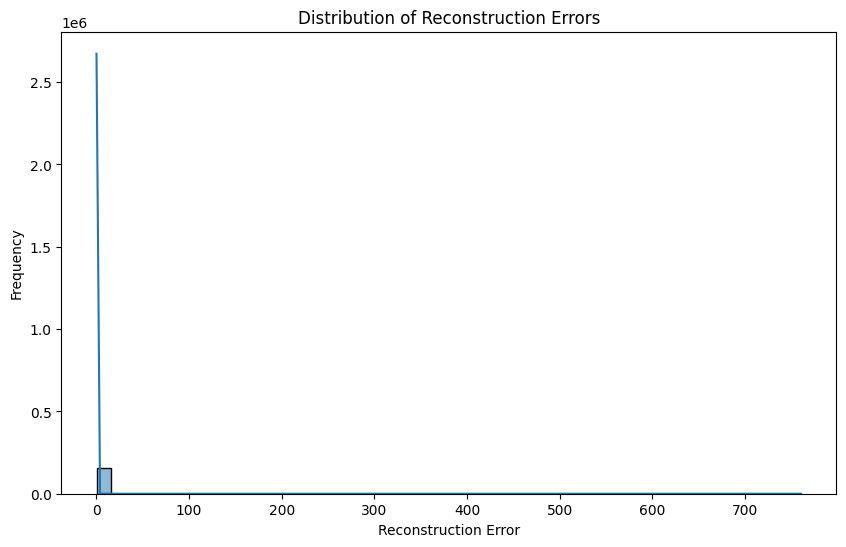

In [6]:
# Reconstruction Error (Most Common)

# Transform data to PC space (already done: principal_components)

# Reconstruct data from PC space back to the original feature space
# 1. Transform principal components back to scaled original space
X_projected_scaled = pca.inverse_transform(principal_components)

# 2. Inverse transform from scaled space back to original units (if needed for interpretation,
#    but for error calculation, scaled-to-scaled is sufficient and often preferred)
#    X_reconstructed = scaler.inverse_transform(X_projected_scaled)

# Calculate reconstruction error (Mean Squared Error per sample)
reconstruction_errors = np.array([mean_squared_error(X_scaled[i, :], X_projected_scaled[i, :])
                                   for i in range(X_scaled.shape[0])])

# Add reconstruction errors to the original DataFrame
df['reconstruction_error'] = reconstruction_errors

# Visualize reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(df['reconstruction_error'], bins=50, kde=True)
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.axvline(x=df.loc[df['is_anomaly'], 'reconstruction_error'].mean(), color='red', linestyle='--', label='Mean Anomaly Error')
plt.legend()
plt.show()

# Set a threshold for anomaly detection (e.g., based on quantile or standard deviation)
# A common approach is to use the 95th or 99th percentile of reconstruction errors from normal data.
# For demonstration, let's use a simple multiplier of the mean or a high percentile.

# Using a percentile threshold
threshold_percentile = 99.5
threshold = np.percentile(df['reconstruction_error'], threshold_percentile)

# Identify anomalies based on the threshold
df['is_anomaly_detected_reconstruction'] = df['reconstruction_error'] > threshold

print(f"\nReconstruction Error Threshold (P{threshold_percentile}): {threshold:.4f}")
print("Anomalies detected by reconstruction error:")
print(df['is_anomaly_detected_reconstruction'].value_counts())

# Evaluate performance (Optional, as we have true labels in this synthetic example)
from sklearn.metrics import confusion_matrix, classification_report
print("\nConfusion Matrix (Reconstruction Error):")
print(confusion_matrix(df['is_anomaly'], df['is_anomaly_detected_reconstruction']))
print("\nClassification Report (Reconstruction Error):")
print(classification_report(df['is_anomaly'], df['is_anomaly_detected_reconstruction']))

# Visualize true anomalies vs. detected anomalies based on reconstruction error
plt.figure(figsize=(12, 7))
sns.scatterplot(x=np.arange(len(df)), y=df['reconstruction_error'], hue=df['is_anomaly'].astype(str),
                style=df['is_anomaly_detected_reconstruction'].astype(str), palette='viridis', s=50)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold_percentile}th percentile)')
plt.title('Reconstruction Error for True Anomalies vs. Detected Anomalies')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend(title='True Anomaly / Detected Anomaly')
plt.grid(True)
plt.show()